# 处理CMP化学研磨过程数据[ok]

In [1]:
# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm
import datetime

import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

In [3]:
# Transformer for time series Class
from utils.transformers_tst.tst import Transformer
from utils.transformers_tst.src.utils import compute_loss
from utils.transformers_tst.src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [4]:
# Plot curve
import utils.functions_plot as PL

## 2. 封装成class类

## 2.1 导入模态I腔室4的训练和测试数据

In [5]:
X_train = np.load("./data phm 2016/X_train_r_modeI_chamber4_mm.npy")
y_train = np.load("./data phm 2016/y_train_modeI_chamber4_mm.npy")
X_test = np.load("./data phm 2016/X_test_r_modeI_chamber4_mm.npy")
y_test = np.load("./data phm 2016/y_test_modeI_chamber4_mm.npy")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (798, 263, 19)
y_train shape:  (798, 1)
X_test shape:  (165, 263, 19)
y_test shape:  (165, 1)


In [6]:
# 基本参数
wafer_number, max_batch_length, variable_number = X_train.shape
wafer_number_test = X_test.shape[0]
print('训练集晶圆个数：', wafer_number)
print('最长时间序列长度：', max_batch_length)
print('字段个数：', variable_number)
print('训练集晶圆个数：', wafer_number_test)

训练集晶圆个数： 798
最长时间序列长度： 263
字段个数： 19
训练集晶圆个数： 165


In [7]:
class CMPModeIChamber4Dataset(Dataset):
    """Torch dataset for Oze datachallenge training.
    Attributes
    ----------
    x: np.array
        Dataset target of shape (wafer_number, seq_length, variable_number).
    
    y: np.array
        Dataset target of shape (wafer_number, 1).
    """

    def __init__(self, dataset_x, dataset_y, **kwargs):
        """Load dataset from csv.
        Parameters
        ---------
        dataset_x: Tuple
            Tuple of shape (wafer_number, seq_length, variable_number).
        dataset_y: Tuple
            Tuple of shape (wafer_number, 1).
        """
        super().__init__(**kwargs)

        self._x = dataset_x.astype(np.float32)
        self._y = dataset_y.astype(np.float32)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self._x[idx], self._y[idx])
    
    def __len__(self):
        return self._x.shape[0]

    def get_x_shape(self):
        """get_x_shape"""
        return self._x.shape

    def get_y_shape(self):
        """get_y_shape"""
        return self._y.shape

In [8]:
cmp_train = CMPModeIChamber4Dataset(X_train, y_train)
cmp_test = CMPModeIChamber4Dataset(X_test, y_test)

In [9]:
dataset_train, dataset_val = random_split(cmp_train, (700, 98), generator=torch.Generator().manual_seed(42))

In [10]:
dataset_test, dataset_null = random_split(cmp_test, (165, 0))

## 超参数

In [11]:
# Training parameters
BATCH_SIZE = 100
NUM_WORKERS = 0
LR = 0.001 #2e-4
EPOCHS = 100 # 可以修改

# Model parameters
d_model = 8 #8 #64 # Lattent dim
q = 4 #8 # Query size
v = 4 #8 # Value size
h = 4 #8 # Number of heads
N = 2 #4 # 4 # Number of encoder and decoder to stack
attention_size = 6 # 12 # Attention window size # 可以修改
dropout = 0.2 # Dropout rate
pe = 'regular'#None # Positional encoding(pe='original' and pe_period=None，或者pe='regular' and pe_period=int)
pe_period = 24
chunk_mode = None # None

d_input = 19 # From dataset 是数据集的feature个数
d_output = 1 # From dataset
K = max_batch_length # From dataset 是采样点个数，也是sequence_length

# Config
# sns.set() # 设置画图的配色
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cpu


In [12]:
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )
dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

## 训练

In [13]:
net = Transformer(d_input, d_model, d_output, K, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe, pe_period=pe_period).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = torch.nn.MSELoss(reduction='mean')

In [14]:
model_save_path = f'./model/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:1d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            # 保存模型
#             torch.save(net.state_dict(), model_save_path)
print('val_loss_best:', val_loss_best)
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

[Epoch 100/100]: 100%|██████████| 700/700 [00:27<00:00, 25.31it/s, loss=31.2, val_loss=26.3]

val_loss_best: 25.707902908325195


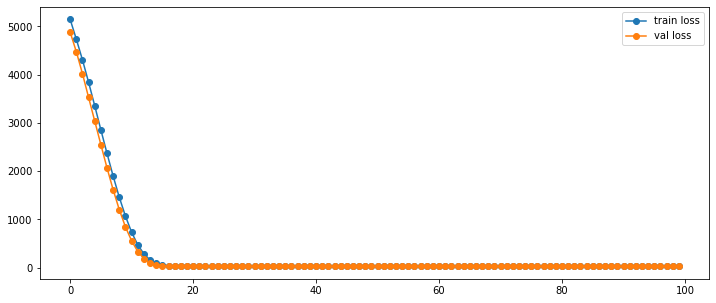

In [15]:
plt.figure(figsize=(12,5))
plt.plot(hist_loss[:], 'o-', label='train loss')
plt.plot(hist_loss_val[:], 'o-', label='val loss')
plt.legend()
plt.show()

In [16]:
# net = pickle.load(open('./results_save/net.pkl', 'rb'))

In [17]:
print(net)

Transformer(
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=8, out_features=16, bias=True)
        (_W_k): Linear(in_features=8, out_features=16, bias=True)
        (_W_v): Linear(in_features=8, out_features=16, bias=True)
        (_W_o): Linear(in_features=16, out_features=8, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=8, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=8, bias=True)
      )
      (_layerNorm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.2, inplace=False)
    )
    (1): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=8, out_features=16, bias=True)
        (_W_k): Linear(in_features=8, out_features=16, bias=True)
        (_W_v): Linear(in_fe

In [18]:
# torch.save(net, './results_save/net.pt')

## Test

In [19]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 1))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


MSE:  56.53828941743559
RMSE:  7.5191947319799874
MAE:  6.05879392467152
R^2:  -0.3715007529316292
max absolute error:  19.975689660644534
min absolute error:  0.21871286621093589
mean absolute error:  6.05879392467152




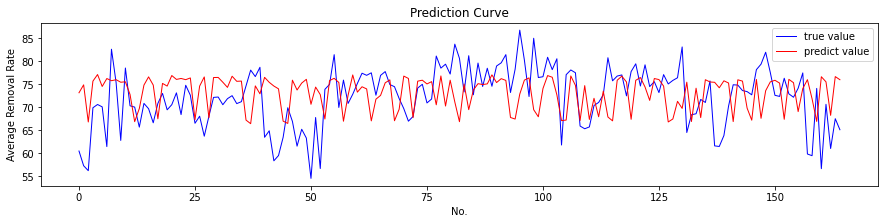

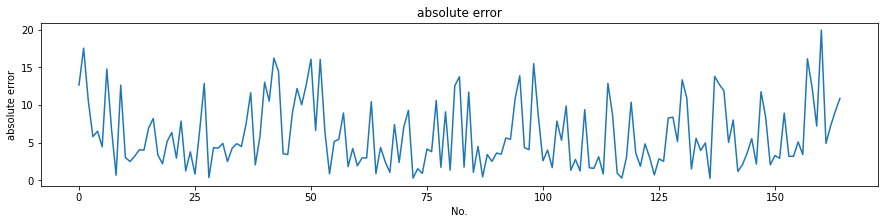

In [20]:
PL.plot_predict_curve(y_test, predictions, show_figure=True)

# Save

In [ ]:
pickle.dump(predictions, open('./results_save/predictions.pkl', 'wb'))
pickle.dump(hist_loss, open('./results_save/train_loss.pkl', 'wb'))
pickle.dump(hist_loss_val, open('./results_save/val_loss.pkl', 'wb'))